# Demonstrate running simulations of custom paradigms

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from psifr import fr

from cymr import cmr
from cymr import network
from cymr import parameters
from cfr import framework

cfr_dir = Path(os.environ['CFR_RESULTS'])

## Set up simulations using the best-fitting CFR model

In [2]:
model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1'
fit_dir = cfr_dir / 'fits' / 'v5' / model_name

subj_param = framework.read_fit_param(fit_dir / 'fit.csv')
param_def = parameters.read_json(fit_dir / 'parameters.json')
patterns = network.load_patterns(cfr_dir / 'cfr_patterns.hdf5')

## Define paradigm to simulate

In [3]:
# just to pick two people and two objects...
items = ['ABRAHAM LINCOLN', 'ADAM SANDLER', 'ACORN', 'ALLENWRENCH']
assert np.all(np.isin(items, patterns['items']))
item_index = [np.where(patterns['items'] == i)[0][0] for i in items]

# best would be to calculate average parameters and use that; here, using
# a subject with a relatively high value of B_enc_cat
subject = 8  

In [4]:
data = pd.DataFrame(
    {
        'subject': np.tile(subject, 4),
        'list': np.ones(4, dtype=int),
        'trial_type': np.tile('study', 4),
        'position': np.arange(1, 5),
        'item': items,
        'item_index': item_index,
    }
)
data

,subject,list,trial_type,position,item,item_index
0,8,1,study,1,ABRAHAM LINCOLN,0
1,8,1,study,2,ADAM SANDLER,1
2,8,1,study,3,ACORN,512
3,8,1,study,4,ALLENWRENCH,513


## Run simulation and record context

In [5]:
model = cmr.CMR()
state = model.record(
    data, {}, subj_param, param_def=param_def, patterns=patterns, include=['c', 'c_in']
)
net = state[0]

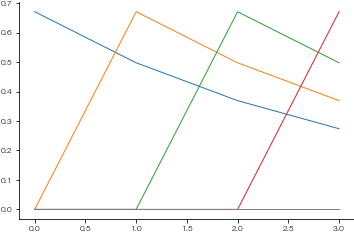

In [6]:
# plot localist units
c_slice = net.get_slice('c', 'loc', 'item')
study_c = np.array([s.c[c_slice] for s in state])
plt.plot(study_c);

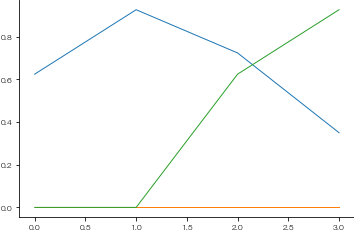

In [7]:
# plot category units
c_slice = net.get_slice('c', 'cat', 'item')
study_c = np.array([s.c[c_slice] for s in state])
plt.plot(study_c);

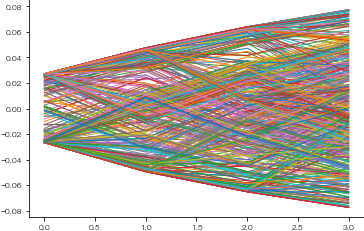

In [8]:
# plot distributional units
c_slice = net.get_slice('c', 'use', 'item')
study_c = np.array([s.c[c_slice] for s in state])
plt.plot(study_c);

## Run simulation and generate recalls

In [9]:
model = cmr.CMR()
sim = model.generate(data, {}, subj_param, param_def=param_def, patterns=patterns)
sim

,subject,list,trial_type,position,item,item_index
0,8,1,study,1,ABRAHAM LINCOLN,0.0
1,8,1,study,2,ADAM SANDLER,1.0
2,8,1,study,3,ACORN,512.0
3,8,1,study,4,ALLENWRENCH,513.0
4,8,1,recall,1,ALLENWRENCH,NaN
5,8,1,recall,2,ACORN,NaN
6,8,1,recall,3,ADAM SANDLER,NaN
7,8,1,recall,4,ABRAHAM LINCOLN,NaN


In [10]:
merged = fr.merge_free_recall(sim)
merged

,subject,list,item,input,output,study,recall,repeat,intrusion
0,8,1,ABRAHAM LINCOLN,1,4,True,True,0,False
1,8,1,ADAM SANDLER,2,3,True,True,0,False
2,8,1,ACORN,3,2,True,True,0,False
3,8,1,ALLENWRENCH,4,1,True,True,0,False
